Grabbing all REHAB member records.
Hack used: The weblink ['https://www.rehab-bd.org/index.php?page=members&rowPerPage=1600'] has an option to control number of entries shown per page. I've changed the numer of rowPerPage to 1600 (REHAB has ~870 members; so, this page should display all members); to make my parsing easier.

In [1]:
import requests
from bs4 import BeautifulSoup

URL = 'https://www.rehab-bd.org/index.php?page=members&rowPerPage=1600'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}


page = requests.get(URL,headers=headers)

# soup = BeautifulSoup(page.content, "html.parser")
page.content

b'\n\n<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="utf-8">\n\n    <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n    <meta name="viewport" content="width=device-width, initial-scale=1"/>\n    <!-- The above 3 meta tags *must* come first in the head; any other head content must come *after* these tags -->\n    <title>Real Estate & Housing Association of Bangladesh</title>\n\n    <!-- Bootstrap -->\n    <link href="css/bootstrap.min.css" rel="stylesheet">\n    <link rel="stylesheet" href="css/jquery-ui.min.css">\n    <link href="css/font-awesome.min.css" rel="stylesheet">\n    <link href="css/app.css" rel="stylesheet">\n    <link href="css/vegas.min.css" rel="stylesheet">\n    <link href="css/slick.css" rel="stylesheet">\n    <link href="css/jquery.fancybox.css" rel="stylesheet">\n    <link rel="icon" href="img/logo.ico"/>\n\n    <!-- HTML5 shim and Respond.js for IE8 support of HTML5 elements and media queries -->\n    <!-- WARNING: Respond.js doesn\'t work if 

In [2]:
import pandas as pd
REHAB_df = pd.read_html(page.content)

pd.read_html outputs a list of tables (if multiple tables are present). Since REHAB has ~870 members, the parsed table that has all REHAB members should have a length close to 870. Here, I check which tables have >100 entries and only one table matches the criteria

In [3]:
for i in range(len(REHAB_df)):
    if len(REHAB_df[i]) > 100:
#         print(REHAB_df.index(i))
        print(i)

8


In [4]:
REHAB_df[8]

,0
0,Total REHAB Members : 870 Records per page: 8 ...
1,Membership No : 778/2010 7-One Properties Lim...
2,Membership No : 1117/2011 A B Developers Ltd....
3,Membership No : 1547/2018 A Class Limited De...
4,Membership No : 1443/2016 A G Green Property ...
...,...
866,Membership No : 1039/2011 Wood Crest Homes Lt...
867,Membership No : 1140/2011 Ya-Habibi Propertie...
868,Membership No : 795/2010 Zaman Property Devel...
869,Membership No : 1371/2013 Zamzam Properties L...


Keeping only the desired table/table contents.

In [5]:
REHAB_member_df = REHAB_df[8]

In [6]:
REHAB_member_df = REHAB_member_df.loc[1:]

Extract info from strings.

In [7]:
# https://www.analyticsvidhya.com/blog/2021/11/3-ways-to-deal-with-settingwithcopywarning-in-pandas/
REHAB_member_df['Membership_No'] = REHAB_member_df[0].str.split(expand=True)[3]
REHAB_member_df['Address'] = REHAB_member_df[0].str.extract('No :\s+(?P<Address>.*) Phone')
REHAB_member_df['Contact_Nos'] = REHAB_member_df[0].str.extract('Phone:\s+(?P<Contact_Nos>.*) E-mail')
REHAB_member_df['E_mail'] = REHAB_member_df[0].str.extract('E-mail:\s+(?P<E_mail>.*)Web:')
REHAB_member_df['Web'] = REHAB_member_df[0].str.extract('Web:\s+(?P<Web>.*)')['Web'].str.strip()
REHAB_member_df['Year_Of_Joining'] = REHAB_member_df.Membership_No.str.split('/', expand=True)[1].astype(int)

C:\Users\Akash\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Akash\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Akash\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [10]:
yearly_count = REHAB_member_df.groupby([REHAB_member_df.Year_Of_Joining]).count()['Membership_No']

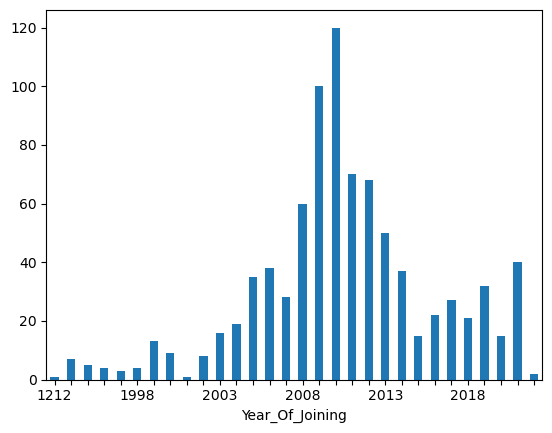

In [11]:
ax = yearly_count.plot(kind='bar', rot=0)
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

It seems one member joined REHAB in 1212. This is certainly not true! We need to fix this.

Approach to fix: It seems the membership number follows the format (Serial Number)/(Year of joining) format. If this is the case, then if we sort all members based on the Serial Number and try to guess what would be the correct year for the entry that shows year of joining as 1212.

In [12]:
# Year 1212 entry:

REHAB_member_df[REHAB_member_df.Year_Of_Joining == 1212]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining
184,Membership No : 1208/1212 China Gardencity De...,1208/1212,1208/1212 China Gardencity Developers Ltd. D...,"9132983,9131562 Fax: +88-02-9140967",info@cgdl.org,http://www.cgdl.org,1212


In [13]:
REHAB_member_df['Memb_No_Year_Stripped'] = REHAB_member_df.Membership_No.str.split('/', expand= True)[0]

C:\Users\Akash\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
REHAB_member_df.Memb_No_Year_Stripped = REHAB_member_df.Memb_No_Year_Stripped.astype(int)

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
REHAB_member_df = REHAB_member_df.sort_values(by='Memb_No_Year_Stripped')
REHAB_member_df.iloc[525:550]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped
795,Membership No : 1157/2011 Takwa Properties (P...,1157/2011,1157/2011 Takwa Properties (Pvt.) Limited De...,"031-2511330,2516445,01670498183,0171842326,",takwaproperties@yahoo.com,http://www.takwabd.com,2011,1157
306,Membership No : 1158/2011 FM Properties Limit...,1158/2011,1158/2011 FM Properties Limited Details Hou...,"8845309,8845315,8401270 Fax: 8401275",technokoki@metrocombd.com,http://www.fmproperties.com.bd,2011,1158
412,Membership No : 1159/2011 J. A. K. Holdings L...,1159/2011,1159/2011 J. A. K. Holdings Limited Details ...,031-2551622 Fax: 031-2554182,info@jakholdingsltd.net,http://www.jakholdingsltd.net,2011,1159
538,Membership No : 1161/2011 Needs Properties Lt...,1161/2011,1161/2011 Needs Properties Ltd. Details 567...,02-9004684,npl_97@yahoo.com,http://www.nplbd.com,2011,1161
569,Membership No : 1166/2011 Office & Home Solut...,1166/2011,1166/2011 Office & Home Solutions (Pvt.) Limi...,"+88-02-8815222,8815223,8856018-20,+88-02-88131...",info@ohs-bd.com,http://www.ohs.bd.com,2011,1166
607,Membership No : 1169/2011 Premium Properties ...,1169/2011,1169/2011 Premium Properties Ltd. Details 4...,"88-02-8391713,88-02-8391714,8391363,8391375,","premiumpropertiesltd@yahoo.com,info.premiumgro...",http://www.premiumgroupbd.com,2011,1169
624,Membership No : 1171/2011 Quantum Real Estate...,1171/2011,1171/2011 Quantum Real Estate Ltd. Details ...,9674158,NaN,NaN,2011,1171
357,Membership No : 1172/2011 Heritage Real Estat...,1172/2011,1172/2011 Heritage Real Estate Ltd. Details ...,9103554 Fax: 9103556,info@heritage-bd.com,http://www.heritage-bd.com,2011,1172
148,Membership No : 1183/2011 Bil-Tec Development...,1183/2011,1183/2011 Bil-Tec Development Ltd Details F...,"9822337,9822338 Fax: 9821408","emdad@bil-tec.com,info@bil-tec.com",http://www.bil-tec.com,2011,1183
159,Membership No : 1184/2011 Brand Maker Propert...,1184/2011,1184/2011 Brand Maker Property Management Lim...,"+88-031-9852193,88-031-2857901-3 Fax: +88-031-...","info@brandmakerproperty.com,info@brandgroupbd....",http://www.brandmakerproperty.com,2011,1184


Serial Numbers 1207 and 1209 both joined REHAB on 2012. Therefore, it is not unreasonable that the Serial Number 1208 also joined REHAB at 2012. Also, it makes sense that 2012 was mistyped as 1212! Therefore, we can assign 2012 to this entry's year of joining.

In [16]:
REHAB_member_df.loc[184, 'Year_Of_Joining'] = 2012

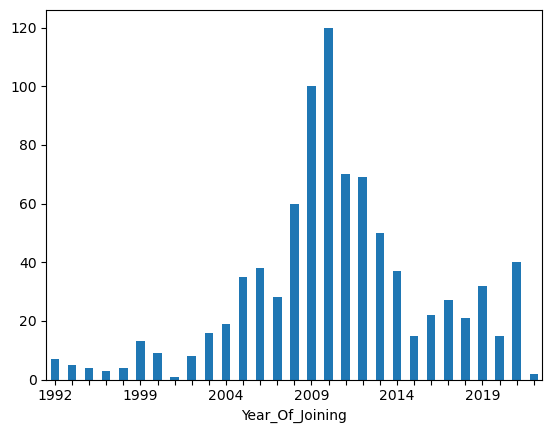

In [17]:
yearly_count = REHAB_member_df.groupby([REHAB_member_df.Year_Of_Joining]).count()['Membership_No']
ax = yearly_count.plot(kind='bar', rot=0)
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

Checking entries with null addresses (in case our regular expression failed).

In [18]:
REHAB_member_df[REHAB_member_df.Address.isna()][0]

847    Membership No : 255/2005  Vertex Builders Limi...
653    Membership No : 1457/2015  Reefa Properties De...
Name: 0, dtype: object

In [21]:
REHAB_member_df.loc[653][0]

'Membership No :\xa01457/2015  Reefa Properties Development Limited  Details  Reefa Properties Development Limited House # 331, Road # 10, Block # D,9th Floor, Bashundhara Main Road, Dhaka-1229. E-mail: msullah@gmail.com'

In [22]:
REHAB_member_df.loc[847][0]

'Membership No :\xa0255/2005  Vertex Builders Limited  Details  House # 387 (1st Floor), Road # 29 DOHS, Mohakhali, Dahaka-1206 Fax: 880-2-8837207  E-mail: vertexbuilders007@gmail.com Web: http://www.vertexdevelopersbd.com'

It seems one failed due to the absence of Phone number and the other failed due to the absence of both phone and fax numbers in their entries. Manually assigning correcnt Addresses for these entries.

In [23]:
REHAB_member_df.loc[653, 'Address'] =  REHAB_member_df.loc[652][0].split('. E-mail')[0]

In [25]:
REHAB_member_df.loc[847, 'Address'] = REHAB_member_df.loc[846][0].split(' Fax')[0]

Extract cities for each REHAB members.

In [26]:
def extract_city(input_string_address):
    x = input_string_address.strip()
    x = x.strip('.').strip(',')
    import re
    if len(re.split('[,\s]', x)) != 1:
        x = re.split('[,\s]', x)[-1]
        x = x.split('-')[0]
    if len(x) == 0:
        print(input_string_address)
#     if x.strip() == 'West Pantapath (Level':
#         print(input_string_address)
    if len(x) != 0:
        print(x)
        return x
    else:
        print(input_string_address)
        return input_string_address


REHAB_member_df['Member_City'] = REHAB_member_df.Address.apply(extract_city)

Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Chittagong
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
1212
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
1213
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Chittagong
Dhaka
Dhaka
1212
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
Dhaka
01733399992
Dhaka
Dhaka
261/2005  Good Luck Real Estates Limited  Details  Shahnewaz Bhaban (1st floor), 9/C, Motijheel C/A, Dhaka -1000.
261/2005  Good Luck Real Estates Limited  Details  Shahnewaz Bhaban (1st floor), 9/C, Motijheel C/A, Dhaka -1000.
Dhaka
Dhaka
Dhaka
Chattogram
Dhaka
Dhaka
Chittagong
Dhaka
Dhaka
1212
Dhaka
19
Dhaka
Dha

In [27]:
REHAB_member_df.Member_City.unique()

array(['Dhaka', 'Chittagong', 'dhaka', '1212', '1213', '01733399992',
       '261/2005  Good Luck Real Estates Limited  Details  Shahnewaz Bhaban (1st floor), 9/C, Motijheel C/A, Dhaka -1000.',
       'Chattogram', '19', 'Bangladesh', '1229', '1217',
       '390/2007  Basic Real Estate Ltd.  Details  House # 79, Road # 12A (1st Floor) Holly Height, Flat # 6B, Dhanmondi R/A, Dhaka .',
       '1215', '1209', 'Narayangonj', 'Sylhet', 'Dhaka.1000', '1207',
       '1216', 'Comilla', '1000', 'Banani.Dhaka', 'Narayongong',
       'naogaon', '1230', 'chittagong', '1205', '3100', 'Mymensing',
       'Gazipur', 'Bogra', 'Khulna', 'Tongi', 'Chattagrom', 'Pabna',
       '1206', 'Motijheel', 'redstoneholdingsltd@gmail.com', 'Manikgong',
       'Chattagram', 'Narayanganj', 'Rangpur', 'Barishal', 'Cumilla'],
      dtype=object)

Seems city name has a lot of variants. Fixing city names.

In [28]:
ctg_list = ['Chittagong', 'Chattogram', 'Chattagrom', 'Chattagram']
cumilla_list = ['Cumilla', 'Comilla' ]
dhaka_list = ['Dhaka', 'Dahaka', 'Motijheel', 'Banani.Dhaka', 'Dhaka.1000' ]
ngong_list = ['Narayanganj', 'Narayangonj', 'Narayongong']

def fix_city(city_name):
    city_name = city_name.strip()
    import re
    if city_name.lower() in [x.lower() for x in dhaka_list]:
        return 'Dhaka'
    elif city_name.lower() in [x.lower() for x in ctg_list]:
        return 'Chittagong'
    elif city_name.lower() in [x.lower() for x in cumilla_list]:
        return 'Comilla'
    elif city_name.lower() in [x.lower() for x in ngong_list]:
        return 'Narayangonj'        
    elif re.match(r'1[0-9][0-9][0-9]', city_name):  # Regular expression to pick up Dhaka zip codes
        return 'Dhaka'
    elif re.match(r'3[0-9][0-9][0-9]', city_name):  # Regular expression to pick up Sylhet zip codes
        return 'Sylhet'
    elif len(city_name) > 50: # Rationale: 2 entries had the whole address. Manual checking revealed they are at 
        return 'Dhaka'        # Dhaka. This is a dirty fix.
    elif city_name == '19':   # Rationale: Only one such entry. Incomplete address. Google search shows this is
        return 'Dhaka'        # at Dhaka
    else:
        return city_name

REHAB_member_df.Member_City = REHAB_member_df.Member_City.apply(fix_city)        

In [29]:
REHAB_member_df.Member_City.value_counts()

Dhaka                            772
Chittagong                        70
Narayangonj                        5
Bangladesh                         4
Comilla                            4
Sylhet                             2
Bogra                              2
Tongi                              1
Rangpur                            1
Manikgong                          1
redstoneholdingsltd@gmail.com      1
Pabna                              1
Gazipur                            1
Khulna                             1
Mymensing                          1
naogaon                            1
01733399992                        1
Barishal                           1
Name: Member_City, dtype: int64

Two entries look clearly wrong. One is an email address and the other is a phone number.

In [33]:
REHAB_member_df[REHAB_member_df.Member_City == '01733399992'].iloc[0][0]

'Membership No :\xa0255/2005  Vertex Builders Limited  Details  House # 387 (1st Floor), Road # 29 DOHS, Mohakhali, Dahaka-1206 Fax: 880-2-8837207  E-mail: vertexbuilders007@gmail.com Web: http://www.vertexdevelopersbd.com'

In [34]:
REHAB_member_df[REHAB_member_df.Member_City == 'redstoneholdingsltd@gmail.com'].iloc[0][0]

'Membership No :\xa01457/2015  Reefa Properties Development Limited  Details  Reefa Properties Development Limited House # 331, Road # 10, Block # D,9th Floor, Bashundhara Main Road, Dhaka-1229. E-mail: msullah@gmail.com'

In [35]:
REHAB_member_df[REHAB_member_df.Member_City == '01733399992']

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City
847,Membership No : 255/2005 Vertex Builders Limi...,255/2005,Membership No : 1414/2014 Venture Engineers &...,NaN,vertexbuilders007@gmail.com,http://www.vertexdevelopersbd.com,2005,255,01733399992


In [36]:
REHAB_member_df[REHAB_member_df.Member_City == 'redstoneholdingsltd@gmail.com']

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City
653,Membership No : 1457/2015 Reefa Properties De...,1457/2015,Membership No : 619/2009 Redstone Holdings Lt...,NaN,NaN,NaN,2015,1457,redstoneholdingsltd@gmail.com


Seems the same to entries have wrong cities! Both are from Dhaka. So, lets assign their city name manually as dhaka.

In [37]:
REHAB_member_df.loc[653, 'Member_City'] = 'Dhaka'
REHAB_member_df.loc[847, 'Member_City'] = 'Dhaka'

There are 4 entries that have Bangladesh as city name. Lets see them first.

In [38]:
for i in REHAB_member_df[REHAB_member_df.Member_City == 'Bangladesh']['Address']: print(i)

288/2006  Nirapad Real Estate & Development Ltd.  Details  House # 09, Road # 09, Sector # 09, Uttara, Dhaka-1230, Bangladesh. 
438/2008  Rahat Properties And Developer Co. Ltd.  Details  Amin Future Park (3rd Floor) 1440/A-3, Strand Road, Gosaildanga Chittagong-4100,Bangladesh.
1211/2012  Al-Muslim Builders Limited  Details  Al-Muslim Group 14 Gedda, Kornopara, Ulail, Savar, Dhaka, Bangladesh
1350/2013  City Home Properties Limited  Details  Apperal Propotes, 6th Floor, 1206/A Nasirabad, 1/A, Bayzid Thana Road, Bayzid, Chattagram, 4210, Bangladesh.


In [39]:
# Fixing city names with Bangladesh.

for i in REHAB_member_df[REHAB_member_df.Member_City == 'Bangladesh'].index:
    if 'Dhaka' in REHAB_member_df.loc[i, 'Address']:
        REHAB_member_df.loc[i, 'Member_City'] = 'Dhaka'
    elif 'Chattagram' in REHAB_member_df.loc[i, 'Address']:
        REHAB_member_df.loc[i, 'Member_City'] = 'Chittagong'
    elif 'Chittagong' in REHAB_member_df.loc[i, 'Address']:
        REHAB_member_df.loc[i, 'Member_City'] = 'Chittagong'

In [40]:
REHAB_member_df.Member_City.value_counts()

Dhaka          776
Chittagong      72
Narayangonj      5
Comilla          4
Sylhet           2
Bogra            2
naogaon          1
Mymensing        1
Gazipur          1
Khulna           1
Tongi            1
Pabna            1
Manikgong        1
Rangpur          1
Barishal         1
Name: Member_City, dtype: int64

City names look good!

### Conclusion
Most of the REHAB members (i.e., builders) are in Dhaka. ~10% are in Chittagong. Not surprising considering Dhaka and Chittagong are the key urban centres in Bangladesh. Kind of points to the centralized aspect of Bangladesh's economic developments.

Now, I want to show the locations of REHAB members on map. To do that, we need longitudes and lattitudes of each of the REHAB members. One way to do that is using google maps geocoding api. For that, we need a google map geocoding api (that allows a certain number of free requests every month). The api can be enabled from google maps api dashboard. I got the api and pasted in a text file named 'API_key.txt'. 

In [41]:
with open('API_key.txt', 'r') as file_handler:
    api_parse = file_handler.read()

In [42]:
#Function to fetch lattitude and longitude from google maps geocoding api.

# https://www.codingforentrepreneurs.com/blog/python-tutorial-google-geocoding-api/

GOOGLE_API_KEY = api_parse # 'your_api_key_from_above' 

def extract_lat_long_via_address(address_or_zipcode):
    lat, lng = None, None
    api_key = GOOGLE_API_KEY
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?key={api_key}&address={address_or_zipcode}"
    # see how our endpoint includes our API key? Yes this is yet another reason to restrict the key
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        return None, None
    try:
        '''
        This try block incase any of our inputs are invalid. This is done instead
        of actually writing out handlers for all kinds of responses.
        '''
        results = r.json()['results'][0]
        lat = results['geometry']['location']['lat']
        lng = results['geometry']['location']['lng']
    except:
        pass
    return lat, lng

In [43]:
REHAB_member_df['lattitude_longitude'] = REHAB_member_df.Address.apply(extract_lat_long_via_address)

In [44]:
REHAB_member_df.to_csv('REHAB_dataframe_with_lat-long.csv')

After manually looking at the entries that failed to fetch lattitude, longitude I realized that the actual address is after the word "Details". So, for the entries with failed lattitude, longitude fetch, here we only use the address (excluding the name) as the search query.

In [45]:
none_none_index = REHAB_member_df[REHAB_member_df['lattitude_longitude'] == (None, None)].Address.index
for i in none_none_index:
    print(REHAB_member_df.loc[i, 'Address'].split('Details',1)[1])
    extracted_address = extract_lat_long_via_address(REHAB_member_df.loc[i, 'Address'].split('Details',1)[1])
    REHAB_member_df.loc[i, 'lattitude'] = extracted_address[0]
    REHAB_member_df.loc[i, 'longitude'] = extracted_address[1]

  bti Celebration Point, Road # 113/A, Plot # 3 & 5, Gulshan, Dhaka
  House # 32, Road # 10, Baridhara, Dhaka 
  Living Rahman House # SW( C ) 12, Road # 07, Gulshan-01, Dhaka-1212
  House # 05, Road # 27, Block # J Banani, Dhaka-1213 
  Concord Centre, 43, North Gulshan C/A, Dhaka-1212 
  Concord Centre, 43, North Gulshan C/A Dhaka-1212 
  4/6, Block # D, Lalmatia, Dhaka-1207
  House # 34/A, Road # 10/A, Dhanmondi, R/A, Dhaka-1209 
  House # 342, Road # 114 Gulshan-2, Dhaka-1212 
  House # 08, Flat # F-2 (2nd Floor) Road # 13 (New) 30 (Old) Dhanmondi R/A, Dhaka-1209 
  (Paradise Bhuiyan Center,7th Floor),1 Chamelibagh,Shantinagar, Dhaka-1217
  House # 157, Road # 12, Block # E, Banani, Dhaka-1213
  House # 01, Road –04, Flat # 5/B, DOHS, Banani, Dhaka-1206 
  Delvistaa Ruparup, SE(H) 6, Road # 143 Gulshan Model Town, Dhaka-1212 
  House # 35, Road # 7, Block # G Banani, Dhaka-1213 
  Union Heights (3rd Floor), (Adjacent to Square Hospital) 55-2, West Panthapath, Dhaka-1205 
  House # 

  156 (2nd Floor),Road # 22,Mohakhali New DOHS,Dhaka-1206
  SM Aabashon Ltd. House # 71, Road # 14, Sector # 13, Uttara Model Town, Dhaka-1230 
  House # 148 (2nd & 3rd Floor), Road # 13/B, Block # E, Banani, Dhaka - 1213.
  House # 472, Road # 31, Mohakhali, DOHS, Dhaka-1206
  House # 439, Main Road (Old), DOHS Mirpur, Dhaka-1216 
  Awal Centre (8th Floor), 34, Kemal Ataturk Avenue Banani, Dhaka-1213
  Flat # 1-B, House # 7, Road # 14/C, Sector # 4, Uttara, Dhaka-1230 
  House # 215/17, Level-09, Road # 06, Block # E, Banosree, Dhaka
  House # 1363 (2nd Floor), Road # 07, Avenue # 03, Mirpur DOHS, Dhaka-1216
  Plot 3 03, Avenue # 2, Block # C, Section # 10, Mirpur, Dhaka-1216
  11, Industrial Plot, Block # C, Tajmohal Road, Mohammadpur, Dhaka-1207
  Sumona Gani Trade Center, Plot # 2, Level # 7, 2 Pantapath, Kawran Bazar, Dhaka-1215 
  House # 39/A, Road # 27 (old) 16 (New) Dhanmondi, Dhaka-1205
  Abiding Reza Tower, Level # 1 & 2, 57/2 Kakrail, Dhaka-1000
  33/6(Ground Floor), Block-

  1397/3, Bagmoniram Road, Kotwali, Chittagong.
  House # 203, Road # 09, New DOHS Mohakhali, Dhaka-1206
  House # 465 (2nd Floor), Road # 31 New DOHS Mohakhali, Dhaka-1206 
  Road # 36, House # 24, Gulshan-02, Dhaka-1212
  House # 11, Road # 04, Dhanmondi, Dhaka-1205
  House # 214 (4th Floor), Lane # 13, Lake Road, New DOHS Mohakhali, Dhaka-1206
  House # 02, Road # 09, Block # G Banani, Dhaka-1213 
  House # 15E, Road # 93, Gulshan-2 Dhaka-1212 
  Bharsa Badsha Palace 66/4, 66/4 A Manik nagar Lake Side, Mugda, Dhaka-1214
  Elvina Ltd. Khan Villa, Level # 06, 1005/10, CDA Avenue, East Nasirabad, Chittagong.
  A G Green Property Development Limited White House , Road # 24, House # 16, Gulshan-1, Dhaka-1212.
  Rabab Holdings Limited House # 274, Road # 20, New DOHS Mohakhali, Dhaka-1206.
  Asiatic Properties Limited 4, Dilkusha C/A , BSS Bhobon (Level # 4), Dhaka-1000.
  Samin Developments Limited Baitul Khair Bhaban, South # 1002 48/A8 Purana Paltan, Dhaka-1000 
  Buildup Technology Lt

Filling up lattitude, longitude from previously retrieved lattitude_longitude string

In [46]:
index_with_lattitude_na = list(REHAB_member_df[REHAB_member_df.lattitude.isna()].index)

for i in index_with_lattitude_na:
    if REHAB_member_df.loc[i, 'lattitude_longitude'] != (None, None):
        REHAB_member_df.loc[i, 'lattitude'] = REHAB_member_df.loc[i, 'lattitude_longitude'][0]
        REHAB_member_df.loc[i, 'longitude'] = REHAB_member_df.loc[i, 'lattitude_longitude'][1]

Enrties with still empty lattitude/longitude fields.

In [ ]:
long_none = REHAB_member_df[REHAB_member_df.longitude.isna()].index
none_set_round_2 = set(long_none) & set(none_none_index)
none_set_round_2

For entries with still failed lat, long - lets just use locality and city name to get approximate lat, long. For example, if a builder is located in Gulshan-2, Dhaka we will just get the lat, long of Gulshan-2, Dhaka.

In [48]:
for i in none_set_round_2:
    print(i)
    parsed_locality = REHAB_member_df.loc[i]['Address'].strip().strip('.').split(',')[-2]
    parsed_city = REHAB_member_df.loc[i]['Address'].strip().strip('.').split(',')[-1]
    location_search_string = parsed_locality + ' , ' + parsed_city
    fetched_lat_long = extract_lat_long_via_address(location_search_string)
    REHAB_member_df.loc[i, 'lattitude'] = fetched_lat_long[0]
    REHAB_member_df.loc[i, 'longitude'] = fetched_lat_long[1]
    print(fetched_lat_long)
    
# REHAB_member_df.loc[852]['Address'].strip().strip('.').split(' ')

512
(23.7738926, 90.411929)
513
(None, None)
3
(23.7820624, 90.4160527)
516
(23.78286, 90.3954387)
5
(23.7516264, 90.394261)
4
(23.7820624, 90.4160527)
519
(23.7504092, 90.39238739999999)
7
(23.8172565, 90.37044859999999)
521
(None, None)
522
(None, None)
520
(23.7947536, 90.41430849999999)
10
(23.7936784, 90.40536639999999)
14
(23.7358533, 90.4037039)
527
(23.7936784, 90.40536639999999)
22
(23.7820624, 90.4160527)
23
(23.7478443, 90.4094777)
537
(23.8354596, 90.36613709999999)
539
(33.1479849, 73.7536695)
27
(23.8379369, 90.36665049999999)
28
(23.78286, 90.3954387)
544
(23.8697964, 90.4219444)
35
(None, None)
548
(23.7703299, 90.3659239)
547
(23.8092605, 90.4134385)
549
(23.7667264, 90.41404179999999)
38
(23.8379369, 90.36665049999999)
43
(23.78286, 90.3954387)
557
(23.8697964, 90.4219444)
559
(23.8172565, 90.37044859999999)
49
(None, None)
51
(23.7936706, 90.4066082)
54
(23.7661639, 90.3588734)
55
(None, None)
568
(23.8092376, 90.41346349999999)
569
(23.7998984, 90.420766)
58
(23.755

In [756]:
none_set_round_3 = set(REHAB_member_df[REHAB_member_df.longitude.isna()].index) & set(none_none_index)
len(none_set_round_3)
# REHAB_member_df.longitude

40

In [777]:
none_set_round_3 = list(none_set_round_3)
for i in none_set_round_3:
    print(i)
    parsed_locality = REHAB_member_df.Address.loc[i].strip().strip('.').split(' ')[-2]
    parsed_city = REHAB_member_df.Address.loc[i].strip().strip('.').split(' ')[-1]
    location_search_string = parsed_locality + ' ' + parsed_city
    fetched_lat_long = extract_lat_long_via_address(location_search_string)
    REHAB_member_df.loc[i, 'lattitude'] = fetched_lat_long[0]
    REHAB_member_df.loc[i, 'longitude'] = fetched_lat_long[1]
    print(fetched_lat_long)

513
(23.7924961, 90.40780579999999)
386
(23.7525863, 90.3729804)
644
(23.8350879, 90.4170875)
388
(None, None)
647
(23.810332, 90.4125181)
776
(23.7998984, 90.420766)
521
(None, None)
137
(23.7461495, 90.3742307)
395
(None, None)
665
(23.810332, 90.4125181)
153
(23.7703299, 90.3659239)
411
(23.7947536, 90.41430849999999)
35
(23.7525863, 90.3729804)
676
(23.7936784, 90.40536639999999)
804
(23.7820624, 90.4160527)
683
(23.7947536, 90.41430849999999)
300
(23.7777571, 90.40574079999999)
686
(23.8092376, 90.41346349999999)
49
(23.8697964, 90.4219444)
820
(23.7461495, 90.3742307)
181
(23.810332, 90.4125181)
182
(23.7936784, 90.40536639999999)
55
(23.7936784, 90.40536639999999)
439
(23.7504092, 90.39238739999999)
827
(23.7936784, 90.40536639999999)
705
(23.8697964, 90.4219444)
455
(23.836468, 90.36953919999999)
73
(23.7947536, 90.41430849999999)
586
(23.7936784, 90.40536639999999)
716
(23.7924961, 90.40780579999999)
333
(23.8154163, 90.53993969999999)
462
(23.8697964, 90.4219444)
83
(23.81033

In [49]:
none_set_round_4 = set(REHAB_member_df[REHAB_member_df.longitude.isna()].index) & set(none_none_index)
len(none_set_round_4)

41

In [50]:
for i in none_set_round_4:
    location_search_string = REHAB_member_df.loc[i].Address.split('P.S #')[-1]
    fetched_lat_long = extract_lat_long_via_address(location_search_string)
    REHAB_member_df.loc[i, 'lattitude'] = fetched_lat_long[0]
    REHAB_member_df.loc[i, 'longitude'] = fetched_lat_long[1]
    print(location_search_string)

1004/2010  Moonstone Properties & Holdings Ltd.  Details  House # 3/B, Road # 49, Block # CWN (A) Gulshan, Dhaka
154/2003  Imperial Development & Holdings Limited  Details  House # 08, Flat # F-2 (2nd Floor) Road # 13 (New) 30 (Old) Dhanmondi R/A, Dhaka-1209 
 Panchlaish,Dist # Chattogram
1466/2016  Rasa Developer Ltd.  Details  Road # 14, House # 01, Nikunja-2 Dhaka-1229
595/2009  RCC Builders Ltd.  Details  Noor Jahan Tower (8th Floor) 2 No. Link Road, Suite # I/1 Bangla Motor, Dhaka-1000 
277/2006  Nabo Uddoge limited  Details  Space SE-2 & SW-2 (1st floor) Nagar Antora Bhaban, Plot # 19 
201/2004  Nagar Builders Ltd.  Details  House # 35, Road # 7, Block # G Banani, Dhaka-1213 
892/2010  BDDL Properties Limited  Details  House # 39/A, Road # 27 (old) 16 (New) Dhanmondi, Dhaka-1205
1089/2011  Innova Properties Limited  Details  House # 31, Level # 3 Gareeb-E-Nawaz Avenue, Dhaka - 1230
310/2006  Bistaar Upodeshta Limited  Details  House # 4/1, (Ground Floor), Block # C Lalmatia, Dhak

In [51]:
none_set_round_5 = set(REHAB_member_df[REHAB_member_df.longitude.isna()].index) & set(none_none_index)
len(none_set_round_5)

40

In [52]:
REHAB_member_df.to_csv('REHAB_dataframe_with_lat-long.csv')

In [53]:
for i in none_set_round_5:
    location_search_string = REHAB_member_df.loc[i].Address.split('#')[-1]
    fetched_lat_long = extract_lat_long_via_address(location_search_string)
    REHAB_member_df.loc[i, 'lattitude'] = fetched_lat_long[0]
    REHAB_member_df.loc[i, 'longitude'] = fetched_lat_long[1]
    print(location_search_string)
    print(fetched_lat_long)

 CWN (A) Gulshan, Dhaka
(23.7924961, 90.40780579999999)
 13 (New) 30 (Old) Dhanmondi R/A, Dhaka-1209 
(23.7525863, 90.3729804)
 01, Nikunja-2 Dhaka-1229
(23.8350879, 90.4170875)
 I/1 Bangla Motor, Dhaka-1000 
(23.810332, 90.4125181)
 19 
(None, None)
 G Banani, Dhaka-1213 
(23.7936784, 90.40536639999999)
 27 (old) 16 (New) Dhanmondi, Dhaka-1205
(23.7439945, 90.3681893)
 3 Gareeb-E-Nawaz Avenue, Dhaka - 1230
(23.8696596, 90.39075199999999)
 C Lalmatia, Dhaka-1207 
(23.7568962, 90.3649196)
1619/2021  Rightway Property & Developer Ltd.  Details  Rightway Property & Developer Ltd. Rightway Airport Plaza, 665/1 & 519 Ashkona Main Road, Dhaka
(None, None)
 93, Gulshan-2 Dhaka-1212 
(23.7947536, 90.41430849999999)
 Dhanmondi, Dhaka-1209 
(23.7525863, 90.3729804)
 131 Gulshan-1, Dhaka-1212
(23.7820624, 90.4160527)
 E Banani, Dhaka-1213
(23.7936784, 90.40536639999999)
 99, Gulshan-2 Dhaka-1212 
(23.7947536, 90.41430849999999)
 31 New DOHS Mohakhali, Dhaka-1206 
(23.78286, 90.3954387)
 32 Mohakh

In [54]:
none_set_round_6 = set(REHAB_member_df[REHAB_member_df.longitude.isna()].index) & set(none_none_index)
len(none_set_round_6)

2

In [57]:
# Remaining lat, long null entries
for i in none_set_round_6:
    print(REHAB_member_df.loc[i]['Address'])

277/2006  Nabo Uddoge limited  Details  Space SE-2 & SW-2 (1st floor) Nagar Antora Bhaban, Plot # 19 
1619/2021  Rightway Property & Developer Ltd.  Details  Rightway Property & Developer Ltd. Rightway Airport Plaza, 665/1 & 519 Ashkona Main Road, Dhaka


In [65]:
extract_lat_long_via_address('519 Ashkona Main Road, Dhaka')

(23.853447, 90.4184093)

In [66]:
for i in none_set_round_6:
    location_search_string = REHAB_member_df.loc[i].Address.split('&')[-1]
    fetched_lat_long = extract_lat_long_via_address(location_search_string)
    REHAB_member_df.loc[i, 'lattitude'] = fetched_lat_long[0]
    REHAB_member_df.loc[i, 'longitude'] = fetched_lat_long[1]
    print(location_search_string)
    print(fetched_lat_long)

 SW-2 (1st floor) Nagar Antora Bhaban, Plot # 19 
(None, None)
 519 Ashkona Main Road, Dhaka
(23.853447, 90.4184093)


In [67]:
REHAB_member_df[REHAB_member_df.lattitude.isna()]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude
521,Membership No : 277/2006 Nabo Uddoge limited ...,277/2006,277/2006 Nabo Uddoge limited Details Space ...,"880-2-8315990,88-02-9114658,9114662,9115423,91...",NaN,NaN,2006,277,Dhaka,"(None, None)",NaN,NaN


In [68]:
REHAB_member_df.to_csv('REHAB_dataframe_with_lat-long.csv')

In [69]:
# There is only one entry that does not have lat, long info. We are going to ignore that ffrom further analysis
REHAB_data_notna = REHAB_member_df[REHAB_member_df.lattitude.notna()]

## Visualizing REHAB member locations on map

We are going to use kepler.gl to visualize REHAB member locations. Kepler.gl is a tool developed by uber and released for free use to visualize geospatial data.

In [70]:
from keplergl import KeplerGl
map_1 = KeplerGl(height=600)
map_1.add_data(data = REHAB_data_notna.fillna(''), name='REHAB data') # We will fill all null values with empty string
map_1

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'REHAB data': {'index': [168, 201, 347, 618, 734, 266, 265, 579, 445, 30, 128, 135, 788, 650, 1…

In [71]:
map_1.save_to_html(file_name='REHAB_map_v1.html')

Map saved to REHAB_map_v1.html!


## Clearly some points have wrong lattitude and longitude info. All REHAB members are in Bangladesh, but this map shows they are scattered throughout the globe!

In [74]:
# We are going to use geopy to get country for each lat, long value pairs. 
# Perhaps this could also be done by google maps api.

# https://www.geeksforgeeks.org/get-the-city-state-and-country-names-from-latitude-and-longitude-using-python/
from geopy.geocoders import Nominatim

# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

# Latitude & Longitude input
Latitude = "38.279116"
Longitude = "-80.850892"
 
location = geolocator.reverse(Latitude+","+Longitude)
 
# Display
# print(location)
location.raw['address']['country_code']

'us'

In [75]:
for i in REHAB_data_notna.index:
    try:
        Lattitude = str(REHAB_data_notna.loc[i, "lattitude"])
        Longitude = str(REHAB_data_notna.loc[i, "longitude"])
        # REHAB_data_notna.loc[i, "country_code"] = geolocator.reverse(Latitude+","+Longitude)
        location = geolocator.reverse(Latitude+","+Longitude)
        REHAB_data_notna.loc[i, "country_code"] = location.raw['address']['country_code']
        print(f'Successful for {i}')
    except:
        REHAB_data_notna.loc[i, "country_code"] = None
        print(f'Failed for {i}')

Successful for 168
Successful for 201
Successful for 347
Successful for 618
Successful for 734
Successful for 266
Successful for 265
Successful for 579
Successful for 445
Successful for 30
Successful for 128
Successful for 135
Successful for 788
Successful for 650
Successful for 187
Successful for 352
Successful for 25
Successful for 331
Successful for 774
Successful for 448
Successful for 182
Successful for 507
Successful for 59
Successful for 756
Successful for 125
Successful for 640
Successful for 823
Successful for 679
Failed for 665
Successful for 809
Successful for 204
Successful for 378
Successful for 726
Successful for 167
Successful for 283
Successful for 203
Successful for 202
Successful for 12
Successful for 101
Successful for 124
Successful for 158
Successful for 540
Successful for 533
Successful for 518
Successful for 437
Successful for 286
Successful for 417
Successful for 72
Successful for 463
Successful for 601
Successful for 693
Successful for 60
Successful for 525
Suc

Successful for 91
Successful for 189
Successful for 96
Successful for 313
Successful for 499
Successful for 393
Successful for 394
Successful for 625
Successful for 434
Successful for 171
Successful for 757
Successful for 830
Successful for 551
Successful for 557
Successful for 707
Successful for 211
Successful for 376
Successful for 117
Successful for 622
Successful for 751
Successful for 821
Successful for 613
Successful for 555
Successful for 596
Successful for 694
Successful for 513
Successful for 547
Successful for 673
Successful for 550
Successful for 140
Successful for 237
Successful for 440
Successful for 79
Successful for 553
Successful for 528
Successful for 173
Successful for 649
Successful for 260
Successful for 856
Successful for 355
Successful for 866
Successful for 196
Successful for 852
Successful for 174
Successful for 383
Successful for 89
Successful for 291
Successful for 441
Successful for 370
Successful for 39
Successful for 21
Successful for 794
Successful for 762

In [76]:
# Function to restrict google map geocode api result to BD only.
GOOGLE_API_KEY = api_parse # 'your_api_key_from_above' 

def extract_lat_long_via_address_bd_restricted(address_or_zipcode):
    lat, lng = None, None
    api_key = GOOGLE_API_KEY
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?key={api_key}&address={address_or_zipcode}&components=country:BD"
    # see how our endpoint includes our API key? Yes this is yet another reason to restrict the key
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299) or r.json()['status'] == 'ZERO_RESULTS':
        return None, None, None
    try:
        '''
        This try block incase any of our inputs are invalid. This is done instead
        of actually writing out handlers for all kinds of responses.
        '''
        results = r.json()['results'][0]
        lat = results['geometry']['location']['lat']
        lng = results['geometry']['location']['lng']
        def get_country_code(results):
            number_address_components = len(results['address_components'])
            for i in range(number_address_components):
                if results['address_components'][-i]['types'][0] == 'country':
                    print(i)
                    print(results['address_components'][-i]['short_name'] )
                    return results['address_components'][-i]['short_name']
        country_code = get_country_code(results)
    except:
        pass
    return lat, lng, country_code

In [77]:
REHAB_data_notna.country_code = REHAB_data_notna.country_code.str.lower()
not_BD_list = list(REHAB_data_notna[REHAB_data_notna.country_code != 'bd'].index)
not_BD_list

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[168,
 201,
 347,
 618,
 734,
 266,
 265,
 579,
 445,
 30,
 128,
 135,
 788,
 650,
 187,
 352,
 25,
 331,
 774,
 448,
 182,
 507,
 59,
 756,
 125,
 640,
 823,
 679,
 665,
 809,
 204,
 378,
 726,
 167,
 283,
 203,
 202,
 12,
 101,
 124,
 158,
 540,
 533,
 518,
 437,
 286,
 417,
 72,
 463,
 601,
 693,
 60,
 525,
 246,
 561,
 122,
 589,
 678,
 841,
 764,
 73,
 179,
 386,
 584,
 457,
 484,
 807,
 722,
 105,
 554,
 94,
 232,
 327,
 526,
 790,
 797,
 298,
 343,
 359,
 522,
 583,
 692,
 833,
 458,
 541,
 796,
 312,
 190,
 316,
 332,
 104,
 720,
 226,
 576,
 701,
 730,
 511,
 402,
 492,
 172,
 439,
 470,
 685,
 387,
 683,
 45,
 748,
 154,
 626,
 847,
 385,
 183,
 330,
 262,
 731,
 489,
 689,
 758,
 749,
 170,
 120,
 13,
 50,
 391,
 490,
 745,
 552,
 723,
 41,
 314,
 842,
 243,
 845,
 475,
 817,
 620,
 870,
 578,
 427,
 153,
 147,
 199,
 785,
 68,
 341,
 95,
 374,
 285,
 344,
 729,
 769,
 185,
 429,
 586,
 42,
 195,
 90,
 152,
 371,
 519,
 534,
 704,
 136,
 35,
 772,
 215,
 404,
 34,
 62,
 592,

BD restricted google map geocode api still sometimes returns non-Bangladesh results. Esp. if the name of the builder matches with some foreign geographic locations. 
The following function keeps on splitting the Address strings based on comma(,)'s present. It will serially reduce the search string size and send search request to google till a Bangladesh result is fetched. For example, if the Address string is 

"XYZ Building, ABC Road, Gulshan, Dhaka" then 
Search 1 will be: "XYZ Building, ABC Road, Gulshan, Dhaka"
Search 2 will be: "ABC Road, Gulshan, Dhaka"
Search 3 will be: "Gulshan, Dhaka"
Search 4 will be: "Dhaka"

The search loop will stop once a BD result is found. In the aforementioned example, Search 3 will definetely give a BD lat, lon. Once a BD result is found, the loop will stop and return that lat, long

In [78]:
def serial_rstrip_till_BD(idx):
    address_string = REHAB_data_notna.loc[idx]['Address']
    address_string = address_string.split(',')
    for i in range(len(address_string)):
        x = extract_lat_long_via_address_bd_restricted(' '.join(address_string[i:]))
        if x[2] == 'BD':
            return x
    return None, None, None 

In [79]:
for i in not_BD_list:
    z = serial_rstrip_till_BD(i)
    REHAB_data_notna.loc[i, 'lattitude'] = z[0]
    REHAB_data_notna.loc[i, 'longitude'] = z[1]
    try:
        REHAB_data_notna.loc[i, 'country_code'] = z[2].lower()
    except:
        REHAB_data_notna.loc[i, 'country_code'] = z[2]
    print(f'Loop completed for {i}')

1
BD
Loop completed for 168
2
BD
Loop completed for 201
2
BD
Loop completed for 347
2
BD
Loop completed for 618
2
BD
Loop completed for 734
2
BD
Loop completed for 266
1
BD
Loop completed for 265
2
BD
Loop completed for 579
2
BD
Loop completed for 445
2
BD
Loop completed for 30
2
BD
Loop completed for 128
2
BD
Loop completed for 135
2
BD
Loop completed for 788
2
BD
Loop completed for 650
2
BD
Loop completed for 187
2
BD
Loop completed for 352
2
BD
Loop completed for 25
2
BD
Loop completed for 331
2
BD
Loop completed for 774
2
BD
Loop completed for 448
1
BD
Loop completed for 182
2
BD
Loop completed for 507
2
BD
Loop completed for 59
2
BD
Loop completed for 756
2
BD
Loop completed for 125
2
BD
Loop completed for 640
2
BD
Loop completed for 823
2
BD
Loop completed for 679
2
GB
2
BD
Loop completed for 665
2
BD
Loop completed for 809
0
BD
Loop completed for 204
2
BD
Loop completed for 378
2
BD
Loop completed for 726
2
BD
Loop completed for 167
2
BD
Loop completed for 283
0
BD
Loop complete

2
BD
Loop completed for 843
2
BD
Loop completed for 227
0
BD
Loop completed for 400
2
BD
Loop completed for 273
2
BD
Loop completed for 22
2
BD
Loop completed for 247
2
BD
Loop completed for 248
0
BD
Loop completed for 270
0
BD
Loop completed for 717
2
BD
Loop completed for 542
2
BD
Loop completed for 565
2
FR
2
BD
Loop completed for 23
2
BD
Loop completed for 604
1
BD
Loop completed for 474
2
BD
Loop completed for 702
1
BD
Loop completed for 466
2
BD
Loop completed for 631
1
DE
1
DE
1
BD
Loop completed for 281
2
BD
Loop completed for 503
2
US
1
BD
Loop completed for 346
1
BD
Loop completed for 405
2
BD
Loop completed for 773
1
BD
Loop completed for 462
2
BD
Loop completed for 781
2
US
2
BD
Loop completed for 24
1
BD
Loop completed for 251
2
PH
2
BD
Loop completed for 479
1
BD
Loop completed for 241
2
BD
Loop completed for 92
1
BD
Loop completed for 606
2
BD
Loop completed for 573
2
BD
Loop completed for 115
2
BD
Loop completed for 245
1
BD
Loop completed for 139
2
BD
Loop completed fo

2
BD
Loop completed for 798
1
US
1
BD
Loop completed for 754
2
BD
Loop completed for 502
1
BD
Loop completed for 76
2
FR
1
BD
Loop completed for 599
1
BD
Loop completed for 641
2
BD
Loop completed for 863
2
BD
Loop completed for 236
2
BD
Loop completed for 787
2
BD
Loop completed for 801
1
BD
Loop completed for 197
1
BD
Loop completed for 712
2
BD
Loop completed for 588
1
BD
Loop completed for 587
2
BD
Loop completed for 19
2
US
2
BD
Loop completed for 340
0
BD
Loop completed for 668
1
BD
Loop completed for 362
1
BD
Loop completed for 360
2
BD
Loop completed for 336
2
BD
Loop completed for 98
2
BD
Loop completed for 399
2
BD
Loop completed for 690
2
BD
Loop completed for 636
2
BD
Loop completed for 703
1
BD
Loop completed for 43
2
BD
Loop completed for 208
2
BD
Loop completed for 397
1
BD
Loop completed for 253
1
BD
Loop completed for 605
2
BD
Loop completed for 643
2
BD
Loop completed for 422
2
BD
Loop completed for 443
1
BD
Loop completed for 705
1
BD
Loop completed for 235
1
BD
Loop

In [81]:
REHAB_data_notna.country_code.value_counts()

bd    867
Name: country_code, dtype: int64

In [83]:
REHAB_data_notna.to_csv('REHAB_dataframe_with_lat-long_BD-restricted.csv')

### Now all entries have Bangladesh lat, log

In [82]:
from keplergl import KeplerGl
map_2 = KeplerGl(height=600)
map_2.add_data(data = REHAB_data_notna.fillna(''), name='REHAB data') # We will fill all null values with empty string
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'REHAB data': {'index': [168, 201, 347, 618, 734, 266, 265, 579, 445, 30, 128, 135, 788, 650, 1…

In [141]:
map_2.save_to_html(file_name='REHAB_map_v2.html')

Map saved to REHAB_map_v2.html!


Eventhough all entries are in BD, some of them appear to be in weird places. For example, there is one close to Satkhira, but it looks like this one is in the middle of nowhere. Closer inspection in of this datapoint (tooltip in kepler.gl) shows that this is actually in Mugda, Dhaka. Below lat, long for these entries are manually fixed. 

In [85]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1436]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
144,Membership No : 1436/2015 Bharsa Housing & De...,1436/2015,1436/2015 Bharsa Housing & Developers Limited...,"88-02-9514049,9564881",NaN,NaN,2015,1436,Dhaka,"(None, None)",22.750357,89.178932,bd


In [90]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1436].iloc[0]['Address']

'1436/2015  Bharsa Housing & Developers Limited.  Details  Bharsa Badsha Palace 66/4, 66/4 A Manik nagar Lake Side, Mugda, Dhaka-1214'

In [92]:
(REHAB_data_notna.loc[144, 'lattitude'],REHAB_data_notna.loc[144, 'longitude']) = extract_lat_long_via_address('66/4 A Manik nagar Lake Side, Mugda, Dhaka-1214')

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [94]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1635]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
425,Membership No : 1635/2021 Kapotakkha Developm...,1635/2021,1635/2021 Kapotakkha Developments Ltd. Detai...,"88-02-222295641,222295992",NaN,NaN,2021,1635,Dhaka,"(22.871482, 89.1283158)",22.871482,89.128316,bd


In [95]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1635].iloc[0]['Address']

'1635/2021  Kapotakkha Developments Ltd.  Details  Kapotakkha Developments Ltd. Flat # 602, House # 15, Road # 128, Gulshan-1, Dhaka-1212'

In [99]:
search_string = 'Gulshan-1, Dhaka-1212'
idx = 425
(REHAB_data_notna.loc[idx, 'lattitude'],REHAB_data_notna.loc[idx, 'longitude']) = extract_lat_long_via_address(search_string)

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [100]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1542]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
635,Membership No : 1542/2018 Rajbari Holdings Lt...,1542/2018,1542/2018 Rajbari Holdings Ltd. Details Raj...,01770006666,kamrul.gdl@gmail.com,http://www.rajbariholdings.com,2018,1542,Dhaka,"(23.7638997, 89.646737)",23.7639,89.646737,bd


In [101]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1542].iloc[0]['Address']

'1542/2018  Rajbari Holdings Ltd.  Details  Rajbari Holdings Ltd. House # 13 (5th Floor), Main Road, Block # A, Bashundhara R/A, Dhaka.'

In [105]:
search_string = 'Bashundhara R/A, Dhaka'
idx = 635
(REHAB_data_notna.loc[idx, 'lattitude'],REHAB_data_notna.loc[idx, 'longitude']) = extract_lat_long_via_address(search_string)

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [106]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1539]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
571,Membership No : 1539/2018 Olympia Holdings Lt...,1539/2018,1539/2018 Olympia Holdings Ltd. Details Oly...,88-02-9880025,holdingsolympia@gmail.com,http://www.olympiaholdingsbd.com .,2018,1539,Dhaka,"(None, None)",25.279387,89.35352,bd


In [107]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1539].iloc[0]['Address']

'1539/2018  Olympia Holdings Ltd.  Details  Olympia Holdings Ltd. Plot # 367, Polashbari, Word # 08, Post : Alia Madrasha, Thana : Ashulia, Dist.: Dhaka '

In [110]:
search_string = 'Ashulia, Dist.: Dhaka'
idx = 571
(REHAB_data_notna.loc[idx, 'lattitude'],REHAB_data_notna.loc[idx, 'longitude']) = extract_lat_long_via_address(search_string)

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [111]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1587]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
816,Membership No : 1587/2020 Total Barakah Housi...,1587/2020,1587/2020 Total Barakah Housing Bangladesh Li...,88-02-55050368,NaN,NaN,2020,1587,Dhaka,"(23.811863, 90.42272919999999)",24.771524,91.545402,bd


In [113]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1587].iloc[0]['Address']

'1587/2020  Total Barakah Housing Bangladesh Limited  Details  RAS Plaza, Ka/11/2 (4th Floor) Jagannathpur, Bashundhara Main Gate, Vatara, Dhaka.'

In [115]:
extract_lat_long_via_address('RAS Plaza, Jagannathpur, Bashundhara Main Gate, Vatara, Dhaka')

(23.80135, 90.4337304)

In [116]:
search_string = 'RAS Plaza, Jagannathpur, Bashundhara Main Gate, Vatara, Dhaka'
idx = 816
(REHAB_data_notna.loc[idx, 'lattitude'],REHAB_data_notna.loc[idx, 'longitude']) = extract_lat_long_via_address(search_string)

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [117]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1638]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
515,Membership No : 1638/2021 Moulovi Real Estate...,1638/2021,1638/2021 Moulovi Real Estate & Construction ...,"88-02-9338968,48314247,01711810544",moulovirealestate@gmail.com,https://www.moulovirealestate.com,2021,1638,Dhaka,"(24.3095344, 91.73149029999999)",24.309534,91.73149,bd


In [118]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1638].iloc[0]['Address']

'1638/2021  Moulovi Real Estate & Construction Ltd.  Details  Moulovi Real Estate & Construction Ltd. Suit # 10/2, Eastern Commercial Complex, 73 Kakrail, Dhaka-1000'

In [120]:
search_string = 'Eastern Commercial Complex, 73 Kakrail, Dhaka-1000'
idx = 515
(REHAB_data_notna.loc[idx, 'lattitude'],REHAB_data_notna.loc[idx, 'longitude']) = extract_lat_long_via_address(search_string)

C:\Users\Akash\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [121]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 911]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
632,Membership No : 911/2010 Rahmania Housing Dev...,911/2010,911/2010 Rahmania Housing Development Limited...,; 88-02-8900040-3 Fax: : 88-02-8960435,housing@rahmaniagroup.com,http://www.rahmaniagroup.com,2010,911,Dhaka,"(22.8288231, 91.6903432)",22.828823,91.690343,bd


In [122]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 911].iloc[0]['Address']

'911/2010  Rahmania Housing Development Limited  Details  Rahmania Mansion, House # 23, Road # 1/C, Nikunja-2, Khilkhet, Dhaka-1229'

In [126]:
search_string = 'Nikunja-2, Khilkhet, Dhaka-1229'
idx = 632
(REHAB_data_notna.loc[idx, 'lattitude'],REHAB_data_notna.loc[idx, 'longitude']) = extract_lat_long_via_address(search_string)

In [134]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1582]

,0,Membership_No,Address,Contact_Nos,E_mail,Web,Year_Of_Joining,Memb_No_Year_Stripped,Member_City,lattitude_longitude,lattitude,longitude,country_code
428,Membership No : 1582/2019 Karnafuly Developer...,1582/2019,1582/2019 Karnafuly Developers (Pvt.) Ltd. D...,01711118298,NaN,NaN,2019.0,1582.0,Comilla,"(22.58188252047576, 92.1068557263428)",22.581883,92.106856,bd


In [135]:
REHAB_data_notna[REHAB_data_notna.Memb_No_Year_Stripped == 1582].iloc[0]['Address']

'1582/2019  Karnafuly Developers (Pvt.) Ltd.  Details  Karnafuly Developers (Pvt.) Ltd. House # 01, Road # 01, Tomsom Bridge, Comilla.'

In [137]:
extract_lat_long_via_address('Tomsom Bridge, Comilla')

(23.4497329, 91.1786163)

In [138]:
search_string = 'Tomsom Bridge, Comilla'
idx = 428
(REHAB_data_notna.loc[idx, 'lattitude'],REHAB_data_notna.loc[idx, 'longitude']) = extract_lat_long_via_address(search_string)

In [139]:
REHAB_data_notna.to_csv('REHAB_dataframe_with_lat-long_BD-restricted.csv')

In [140]:
from keplergl import KeplerGl
map_3 = KeplerGl(height=600)
map_3.add_data(data = REHAB_data_notna.fillna(''), name='REHAB data') # We will fill all null values with empty string
map_3

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'REHAB data': {'index': [168, 201, 347, 618, 734, 266, 265, 579, 445, 30, 128, 135, 788, 650, 1…

In [142]:
map_3.save_to_html(file_name='REHAB_map_v3.html')

Map saved to REHAB_map_v3.html!
